In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Importing all necessary libraries

%load_ext autoreload
%autoreload 2

# internal packages
    
import os
from collections import Counter
# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.metrics import normalized_mutual_info_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import clustpy
from clustpy.deep import encode_batchwise, get_dataloader
from clustpy.alternative import NrKmeans
from clustpy.metrics.multipe_labelings_scoring import MultipleLabelingsConfusionMatrix
import joblib 

# specify base paths

base_path = "/mnt/data/miklautzl92dm_data/clustpy/material"
model_name = "acedec_convae.pth"

print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("clustpy:", clustpy.__version__)

Versions
torch:  2.0.1
torchvision:  0.15.2
numpy:  1.25.2
scikit-learn: 1.3.0
clustpy: 0.0.2-beta


In [3]:
# Some helper functions, you can ignore those in the beginning
def denormalize_fn(array:np.array, mean:float, std:float, w:int, h:int,c=1)->torch.Tensor:
    """
    This applies an inverse z-transformation and reshaping to visualize the images properly.
    """
    tensor = torch.from_numpy(array).float()
    pt_std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    pt_mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    return (tensor.mul(pt_std).add(pt_mean).view(-1, c, h, w) * 255).int().detach()

def plot_images(images:torch.Tensor, pad:int=1):
    """Aligns multiple images on an N by 8 grid"""
    def imshow(img):
        plt.figure(figsize=(10, 20))
        npimg = img.numpy()
        npimg = np.array(npimg)
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)),
                   vmin=0, vmax=1)
    
    imshow(torchvision.utils.make_grid(images, pad_value=255, normalize=False, padding=pad))
    plt.show()
    
def detect_device():
    """Automatically detects if you have a cuda enabled GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
    return device

# Load and prepare Mnist

In [4]:
from clustpy.data import load_mnist


# load data   
dataset = load_mnist()
data = dataset.images
print(type(data))
print(data.shape)
print("1")

labels = dataset.target
data = data.reshape(-1, 1, 28, 28)
print(type(data))
print(data.shape)
print("2")

data = torch.from_numpy(data).float()
print(type(data))
print(data.shape)
print("3")


data = data.repeat(1,3,1,1)
print(type(data))
print(data.shape)
print("4")


padding_fn = torchvision.transforms.Pad([2,2], fill=0)
data = padding_fn(data)
print(type(data))
print(data.shape)
print("5")



data /= 255.0
print(type(data))
print(data.shape)
print("6")



mean = data.mean()
std = data.std()
denormalize = lambda x: denormalize_fn(x, mean=mean, std=std, w=32, h=32, c=3)


# preprocessing functions
normalize_fn = torchvision.transforms.Normalize([mean], [std])
flatten_fn = torchvision.transforms.Lambda(torch.flatten)

# augmentation transforms
transform_list = [
    torchvision.transforms.ToPILImage(),
    # Perform it before cropping causes more computational overhead, but produces less artifacts
    torchvision.transforms.RandomAffine(degrees=(-16,+16),
                                                translate=(0.1, 0.1),
                                                shear=(-8, 8),
                                                fill=0),
    torchvision.transforms.ToTensor(),
    normalize_fn,
]

aug_transforms = torchvision.transforms.Compose(transform_list)
orig_transforms = torchvision.transforms.Compose([normalize_fn])

# pass transforms to dataloader
aug_dl = get_dataloader(data, batch_size=32, shuffle=False, 
                        ds_kwargs={"aug_transforms_list":[aug_transforms], "orig_transforms_list":[orig_transforms]},
                        )

<class 'numpy.ndarray'>
(70000, 28, 28)
1
<class 'numpy.ndarray'>
(70000, 1, 28, 28)
2
<class 'torch.Tensor'>
torch.Size([70000, 1, 28, 28])
3
<class 'torch.Tensor'>
torch.Size([70000, 3, 28, 28])
4
<class 'torch.Tensor'>
torch.Size([70000, 3, 32, 32])
5
<class 'torch.Tensor'>
torch.Size([70000, 3, 32, 32])
6
probable MinMax normalized data detected


# Implementation of Data Set with Augmentation With Example for MNIST

In [6]:
aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, 
                        ds_kwargs={"aug_transforms_list":[aug_transforms], "orig_transforms_list":[orig_transforms]},
                        dl_kwargs={"num_workers":8})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, 
                        ds_kwargs={"orig_transforms_list":[orig_transforms]},
                        dl_kwargs={"num_workers":8})
                        
dl = get_dataloader(data, 256, shuffle=False,
                   ds_kwargs={"orig_transforms_list":[orig_transforms]})

probable MinMax normalized data detected
probable MinMax normalized data detected
probable MinMax normalized data detected


Plot some images to see if everything worked:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


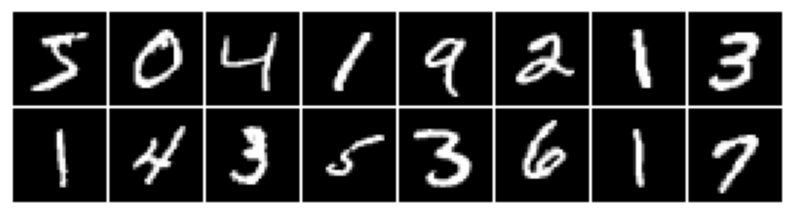

torch.Size([32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])


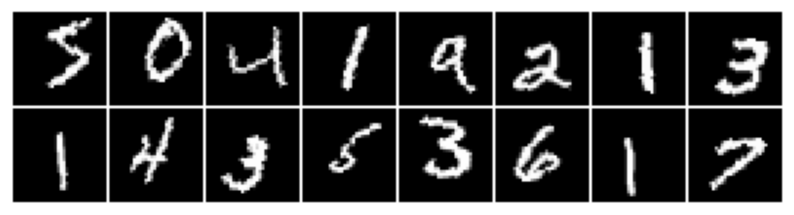

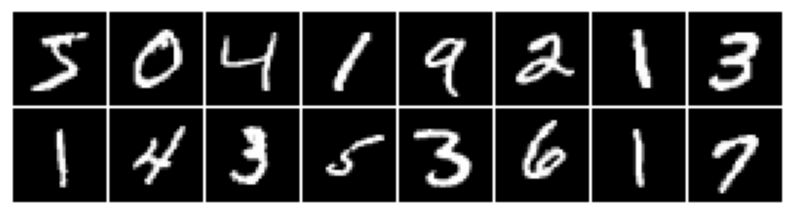

In [7]:
print("Plot some images to see if everything worked:")

plot_images(data[0:16])

for aug_batch in aug_dl:
    for aug_mb in aug_batch:
        print(aug_mb.shape)
    break
plot_images(denormalize(aug_batch[1][0:16].numpy()))
plot_images(denormalize(aug_batch[2][0:16].numpy()))

# Pretrain Autoencoder

In [6]:
from clustpy.deep.autoencoders import ConvolutionalAutoencoder

device = torch.device("cuda:0")
model_path = os.path.join(base_path, model_name)
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)

In [10]:
# Only used to get a parameter count of the used backbone model
# Can be installed with
# pip install torchinfo or conda install -c conda-forge torchinfo
# Github link: https://github.com/TylerYep/torchinfo

from torchinfo import summary
summary(ae, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
ConvolutionalAutoencoder                           [1, 3, 32, 32]            --
├─ResNetEncoder: 1-1                               [1, 512]                  --
│    └─Conv2d: 2-1                                 [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 16, 16]           128
│    └─ReLU: 2-3                                   [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                              [1, 64, 8, 8]             --
│    └─Sequential: 2-5                             [1, 64, 8, 8]             --
│    │    └─EncoderBlock: 3-1                      [1, 64, 8, 8]             73,984
│    │    └─EncoderBlock: 3-2                      [1, 64, 8, 8]             73,984
│    └─Sequential: 2-6                             [1, 128, 4, 4]            --
│    │    └─EncoderBlock: 3-3                      [1, 128, 4, 4]            230,144
│    │    └─Encode

In [11]:
# install pytorch_warmup from https://pypi.org/project/pytorch-warmup/
# with
# pip install -U pytorch_warmup
import pytorch_warmup as warmup
from torch.optim.lr_scheduler import CosineAnnealingLR

class CosineSchedulerWithLinearWarmup(object):
    def __init__(self, optimizer, warmup_period, T_max, eta_min=0, last_epoch=-1, verbose=False):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_period = warmup_period
        self.warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=warmup_period)
        self.cosine_scheduler =  CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min, last_epoch=last_epoch, verbose=verbose)       
    def step(self):
        with self.warmup_scheduler.dampening():
            self.cosine_scheduler.step()

In [27]:
TRAIN = True
weight_decay = 0.01
ae_lr = 1e-3
if TRAIN:
    # n_epochs = 50 # uncomment to return to og state
    n_epochs = 100
    warmup_factor = 0.3
    warmup_period = int(warmup_factor*n_epochs)
    scheduler = CosineSchedulerWithLinearWarmup
    scheduler_params = {"warmup_period":warmup_period, "T_max":n_epochs, "verbose":True}
    ae.fit(n_epochs=n_epochs, optimizer_params={"lr":ae_lr}, 
           # uncomment if augmentation should be used during pretraining
           dataloader=aug_train_dl,
#          dataloader=train_dl,
           device=device, print_step=5, model_path=model_path,
           optimizer_class=lambda params, lr: torch.optim.AdamW(params, lr, weight_decay=weight_decay), scheduler=scheduler, scheduler_params=scheduler_params)
else:
    sd = torch.load(model_path)
    ae.load_state_dict(sd)
    ae.fitted = True

X is None
Adjusting learning rate of group 0 to 3.3333e-05.


C:\Users\Chris\anaconda3\envs\Masterarbeit\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Adjusting learning rate of group 0 to 9.9975e-04.
Epoch 1/99 - Batch Reconstruction loss: 0.152415
Adjusting learning rate of group 0 to 9.9901e-04.
Adjusting learning rate of group 0 to 9.9778e-04.
Adjusting learning rate of group 0 to 9.9606e-04.
Adjusting learning rate of group 0 to 9.9384e-04.
Adjusting learning rate of group 0 to 9.9114e-04.
Epoch 6/99 - Batch Reconstruction loss: 0.155821
Adjusting learning rate of group 0 to 9.8796e-04.
Adjusting learning rate of group 0 to 9.8429e-04.
Adjusting learning rate of group 0 to 9.8015e-04.
Adjusting learning rate of group 0 to 9.7553e-04.
Adjusting learning rate of group 0 to 9.7044e-04.
Epoch 11/99 - Batch Reconstruction loss: 0.146249
Adjusting learning rate of group 0 to 9.6489e-04.
Adjusting learning rate of group 0 to 9.5888e-04.
Adjusting learning rate of group 0 to 9.5241e-04.
Adjusting learning rate of group 0 to 9.4550e-04.
Adjusting learning rate of group 0 to 9.3815e-04.
Epoch 16/99 - Batch Reconstruction loss: 0.161065
Ad

In [28]:
torch.save(ae, "test-convae_reproduce_model_trained_100.pth")
model_path= "test-convae_reproduce_model_trained_100.pth"

In [14]:
from clustpy.deep import encode_decode_batchwise


emb, rec = encode_decode_batchwise(dl, ae, device)


probable MinMax normalized data detected


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


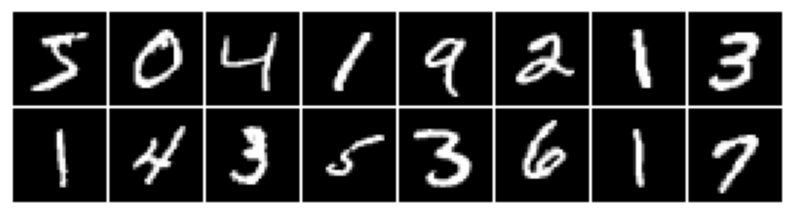

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


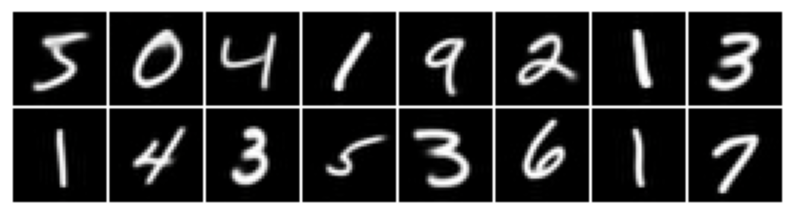

In [30]:
plot_images(data[0:16])
plot_images(denormalize(rec[0:16]))

In [31]:
from sklearn.metrics import adjusted_rand_score as ari

from sklearn.cluster import KMeans

kmeans = KMeans(10)
kmeans.fit(emb)
km_ari = ari(labels, kmeans.labels_)
print(f"ARI: {km_ari}")

C:\Users\Chris\anaconda3\envs\Masterarbeit\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI: 0.7417534877490858


# Apply ACeDeC without augmentation and without invariance

probable MinMax normalized data detected
probable MinMax normalized data detected
probable MinMax normalized data detected
Custom dataloaders are used, X will be overwritten with testloader return values.
negative data values found
probable z-normalized data detected
Setup autoencoder
Run init:  acedec
Start encoding
Start initializing parameters
init params
acedec
None
{'lr': 0.0005}
<class 'torch.optim.adam.Adam'>
negative data values found
Normalization check was inconclusive - make sure your data is normalised
mean -0.90695775
std 6.676469
max 26.991945
min -37.436928
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger than data dimensionality
Round 0: Found solution with: 2772101.484937464 (current best: 2772101.484937464)
Round 1: Found solution with: 2772931.689867175 (current best: 2772101.484937464)
Round 2: Found solution with: 2899456.4595822967 (current best: 2772101.484937464)
Round 3: Found solution with: 2648044.32086622

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


enrc predict batchwise [[2 0]
 [6 0]
 [9 0]
 ...
 [9 0]
 [2 0]
 [4 0]]
enrc predict batchwise shape (70000, 2)
Betas after reclustering
[[5.6130034e-01 5.0513893e-01 5.0823176e-01 5.0854439e-01 9.4084710e-01
  5.2618974e-01 9.9997783e-01 7.2968704e-01 9.9999809e-01 9.8722988e-01]
 [4.3869969e-01 4.9486107e-01 4.9176821e-01 4.9145561e-01 5.9152849e-02
  4.7381029e-01 2.2167573e-05 2.7031294e-01 1.9592419e-06 1.2770070e-02]]
ARI: 0.9242305918983527
ARI-no-reclustering: 0.9303133998513731


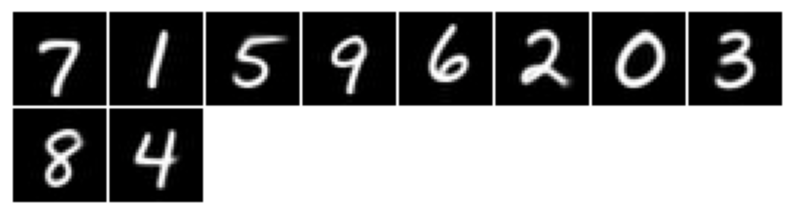

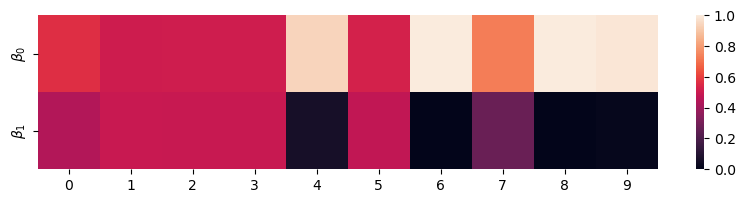

In [5]:
from clustpy.deep.enrc import ACeDeC
from clustpy.deep.autoencoders import ConvolutionalAutoencoder
from sklearn.metrics import adjusted_rand_score as ari
device = torch.device("cuda:0")
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)
model_path = "test-convae_reproduce_model_trained_100.pth"
sd = torch.load(model_path)
ae.load_state_dict(sd.state_dict())
ae.fitted = True
ae.to(device)

aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"aug_transforms_list":[aug_transforms, None], "orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

dl = get_dataloader(data, 256, shuffle=False, additional_inputs=labels,
                   ds_kwargs={"orig_transforms_list":[orig_transforms, None]})

ae_lr = 1e-3
clustering_epochs = 50
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}



acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          )

acedec.fit(data)

acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ARI: 0.7023834331885837
ARI-no-reclustering: 0.5908987321135304


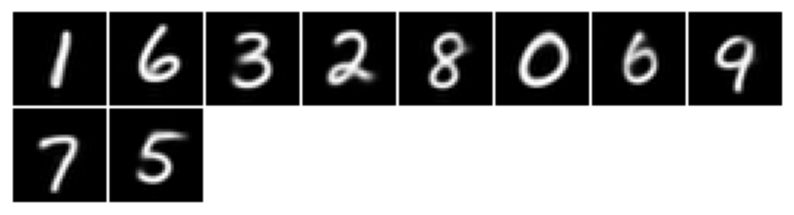

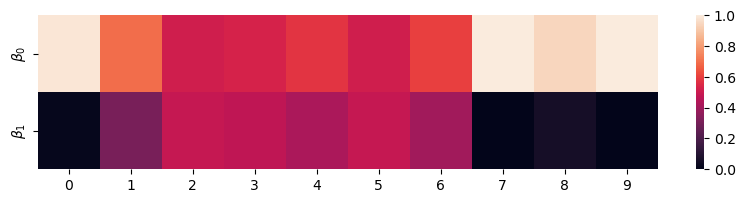

In [16]:
from sklearn.metrics import adjusted_rand_score as ari
acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();

In [17]:
cluster_labels = acedec.predict(X=None, dataloader=dl, use_P=False)
acedec_ari2 = ari(labels, cluster_labels)
print(f"ARI: {acedec_ari2}")

ARI: 0.6840892924179457


# Apply my AceDec (semi-supervised using dec) without Augmentation and invariance

probable MinMax normalized data detected
probable MinMax normalized data detected
probable MinMax normalized data detected
[10, 1]
setup acedec
setup dataloaders
subsample
size 10000
probable MinMax normalized data detected
setup autoencoder
get embedded data
init params
acedec
None
{'lr': 0.0005}
<class 'torch.optim.adam.Adam'>
negative data values found
Normalization check was inconclusive - make sure your data is normalised
mean -0.9060144
std 6.678676
max 30.204445
min -36.192608
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger than data dimensionality
Round 0: Found solution with: 2877038.665485783 (current best: 2877038.665485783)
Round 1: Found solution with: 2506804.851200154 (current best: 2506804.851200154)
Round 2: Found solution with: 2652808.9508832693 (current best: 2506804.851200154)
Round 3: Found solution with: 2649843.0987483845 (current best: 2506804.851200154)
Round 4: Found solution with: 2645497.7652966334 (cur

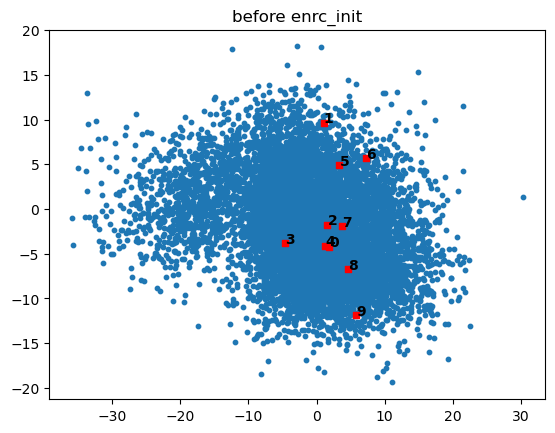

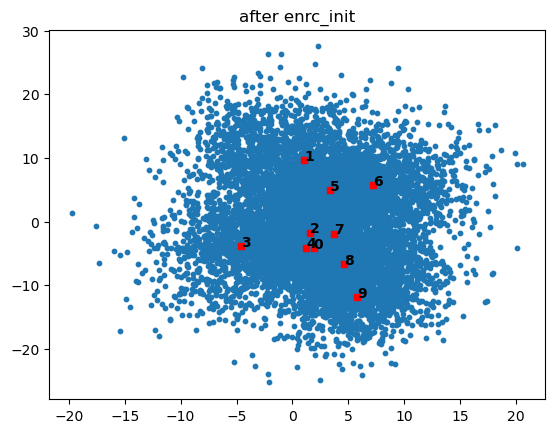

Run ACeDeC init:  acedec
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 5.0000e-04.
Adjusting learning rate of group 2 to 5.0000e-03.
Start ACEDEC training
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 1 to 2.5000e-04.
Adjusting learning rate of group 2 to 2.5000e-03.
Epoch 1/4: summed_loss: 0.3625, subspace_losses: 0.1491, rec_loss: 0.2133,rotation_loss: rotation loss not calculated
Adjusting learning rate of group 0 to 1.2500e-04.
Adjusting learning rate of group 1 to 1.2500e-04.
Adjusting learning rate of group 2 to 1.2500e-03.
Adjusting learning rate of group 0 to 6.2500e-05.
Adjusting learning rate of group 1 to 6.2500e-05.
Adjusting learning rate of group 2 to 6.2500e-04.
Adjusting learning rate of group 0 to 3.1250e-05.
Adjusting learning rate of group 1 to 3.1250e-05.
Adjusting learning rate of group 2 to 3.1250e-04.
Epoch 4/4: summed_loss: 0.2286, subspace_losses: 0.0763, rec_loss: 0.1522,rotation_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


enrc predict batchwise [[7 0]
 [4 0]
 [6 0]
 ...
 [6 0]
 [7 0]
 [7 0]]
enrc predict batchwise shape (70000, 2)
Betas after reclustering
[[6.52103245e-01 9.99902487e-01 9.74240363e-01 5.09690881e-01
  9.84458208e-01 5.92749774e-01 8.87072563e-01 6.02499664e-01
  5.11576891e-01 5.00147700e-01]
 [3.47896785e-01 9.74632130e-05 2.57596262e-02 4.90309060e-01
  1.55417230e-02 4.07250166e-01 1.12927414e-01 3.97500366e-01
  4.88423049e-01 4.99852329e-01]]
ARI: 0.6625276079891108
ARI-no-reclustering: 0.8144995139063346


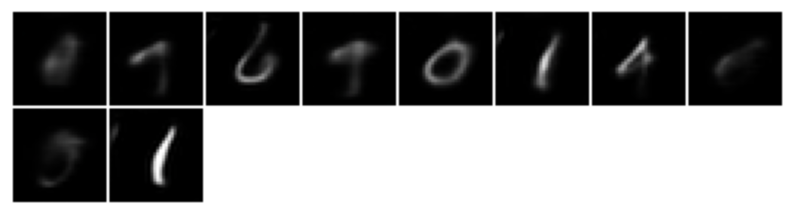

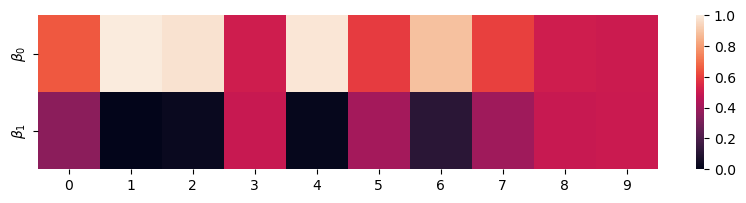

In [9]:
from clustpy.deep.acedec import ACEDEC
from clustpy.deep.autoencoders import ConvolutionalAutoencoder
from sklearn.metrics import adjusted_rand_score as ari
import torch
device = torch.device("cuda:0")
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)
model_path = "test-convae_reproduce_model_trained_100.pth"
sd = torch.load(model_path)
ae.load_state_dict(sd.state_dict())
ae.fitted = True
ae.to(device)

aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"aug_transforms_list":[aug_transforms, None], "orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

dl = get_dataloader(data, 256, shuffle=False, additional_inputs=labels,
                   ds_kwargs={"orig_transforms_list":[orig_transforms, None]})


ae_lr = 1e-3
clustering_epochs = 5
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}



my_acedec = ACEDEC(n_clusters=10,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5, 'epochs': clustering_epochs},
          custom_dataloaders=[train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          reclustering_kwargs={'lr': ae_lr*0.5}
          )


my_acedec.fit(data)
my_acedec_ari = ari(labels, my_acedec.labels_)
print(f"ARI: {my_acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, my_acedec.acedec_labels_)}")

rec_centers = my_acedec.reconstruct_subspace_centroids(0)
plot_images(denormalize(rec_centers))


# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(my_acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


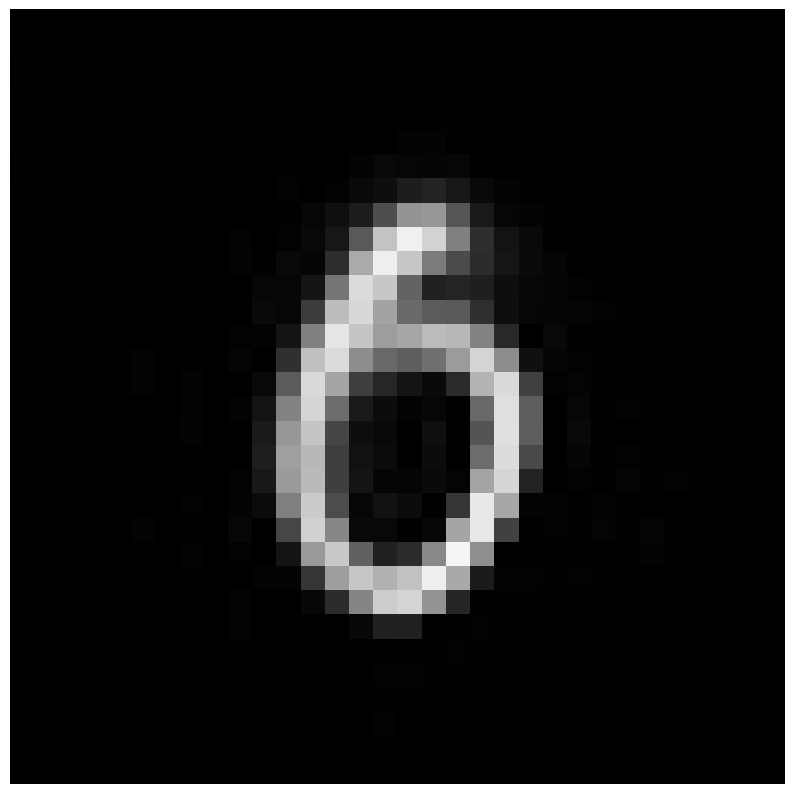

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


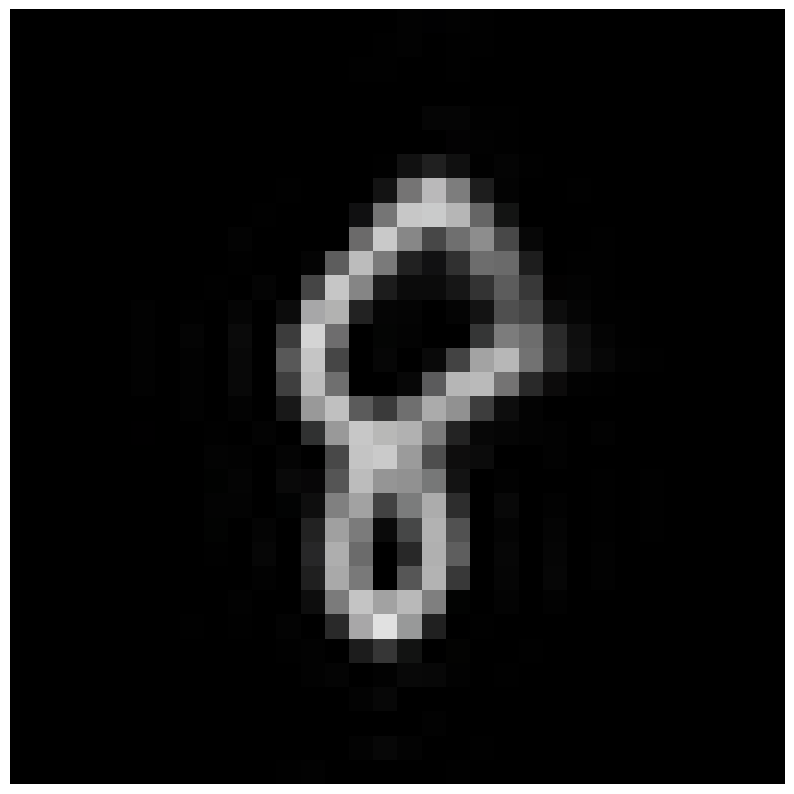

In [12]:
# plot the noise spaces
rec_centers = acedec.reconstruct_subspace_centroids(1)
plot_images(denormalize(rec_centers))
rec_centers = my_acedec.reconstruct_subspace_centroids(1)
plot_images(denormalize(rec_centers))

# Apply to new semisupervised ENRC/AceDEC


In [ ]:
from clustpy.deep.semisupervised_enrc.semi_supervised_acedec import ACeDeC
from clustpy.deep.autoencoders import ConvolutionalAutoencoder
from sklearn.metrics import adjusted_rand_score as ari
device = torch.device("cuda:0")
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)
model_path = "test-convae_reproduce_model_trained_100.pth"
sd = torch.load(model_path)
ae.load_state_dict(sd.state_dict())
ae.fitted = True
ae.to(device)

aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"aug_transforms_list":[aug_transforms, None], "orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

dl = get_dataloader(data, 256, shuffle=False, additional_inputs=labels,
                   ds_kwargs={"orig_transforms_list":[orig_transforms, None]})

ae_lr = 1e-3
clustering_epochs = 5
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}

init_method = "acedec"
loss_function = "acedec"
reclustering_function = "acedec"
fit_function = "acedec"

acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          fit_function=fit_function,
          init=init_method,
          )

acedec.fit(data)

acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();

# Testing the new approach: passing a new training procedure

In [8]:
import torch
import numpy as np
from clustpy.deep._utils import encode_batchwise, detect_device
from clustpy.deep._data_utils import get_dataloader
from clustpy.deep._train_utils import get_trained_autoencoder
from clustpy.deep.semisupervised_enrc.semi_supervised_enrc_init import apply_init_function
from clustpy.deep.semisupervised_enrc.semi_supervised_enrc_module import _ENRC_Module


def _my_fitting_procedure(X: np.ndarray, n_clusters: list, V: np.ndarray, P: list, input_centers: list, batch_size: int,
          pretrain_optimizer_params: dict, clustering_optimizer_params: dict, pretrain_epochs: int, clustering_epochs: int,
          tolerance_threshold: float,
          optimizer_class: torch.optim.Optimizer, loss_fn: torch.nn.modules.loss._Loss,
          degree_of_space_distortion: float, degree_of_space_preservation: float, autoencoder: torch.nn.Module,
          embedding_size: int, init: str, random_state: np.random.RandomState, device: torch.device,
          scheduler: torch.optim.lr_scheduler, scheduler_params: dict,  init_kwargs: dict,
          init_subsample_size: int, custom_dataloaders: tuple, augmentation_invariance: bool, final_reclustering:bool,
          debug: bool, clustering_module: torch.nn.Module) -> (
        np.ndarray, list, np.ndarray, list, np.ndarray, list, list, torch.nn.Module):
    """
    Start the actual ENRC clustering procedure on the input data set.

    Parameters
    ----------
    X : np.ndarray
        input data
    n_clusters : list
        list containing number of clusters for each clustering
    V : np.ndarray
        orthogonal rotation matrix
    P : list
        list containing projections for each clustering
    input_centers : list
        list containing the cluster centers for each clustering
    batch_size : int
        size of the data batches
    pretrain_optimizer_params : dict
        parameters of the optimizer for the pretraining of the autoencoder, includes the learning rate
    clustering_optimizer_params: dict
        parameters of the optimizer for the actual clustering procedure, includes the learning rate
    pretrain_epochs : int
        number of epochs for the pretraining of the autoencoder
    clustering_epochs : int
        maximum number of epochs for the actual clustering procedure
    optimizer_class : torch.optim.Optimizer
        optimizer for pretraining and training
    loss_fn : torch.nn.modules.loss._Loss
        loss function for the reconstruction
    degree_of_space_distortion : float
        weight of the cluster loss term. The higher it is set the more the embedded space will be shaped to the assumed cluster structure
    degree_of_space_preservation : float
        weight of regularization loss term, e.g., reconstruction loss
    autoencoder : torch.nn.Module
         the input autoencoder. If None a new autoencoder will be created and trained
    embedding_size : int
        size of the embedding within the autoencoder. Only used if autoencoder is None
    init : str
        strchoose which initialization strategy should be used. Has to be one of 'nrkmeans', 'random' or 'sgd'.
    random_state : np.random.RandomState
        use a fixed random state to get a repeatable solution
    device : torch.device
        if device is None then it will be checked whether a gpu is available or not
    scheduler : torch.optim.lr_scheduler
        learning rate scheduler that should be used
    scheduler_params : dict
        dictionary of the parameters of the scheduler object
    tolerance_threshold : float
        tolerance threshold to determine when the training should stop. If the NMI(old_labels, new_labels) >= (1-tolerance_threshold)
        for all clusterings then the training will stop before max_epochs is reached. If set high than training will stop earlier then max_epochs, and if set to 0 or None the training
        will train as long as the labels are not changing anymore.
    init_kwargs : dict
        additional parameters that are used if init is a callable
    init_subsample_size : int
        specify if only a subsample of size 'init_subsample_size' of the data should be used for the initialization
    custom_dataloaders : tuple
        tuple consisting of a trainloader (random order) at the first and a test loader (non-random order) at the second position.
        If None, the default dataloaders will be used
    augmentation_invariance : bool
        If True, augmented samples provided in custom_dataloaders[0] will be used to learn
        cluster assignments that are invariant to the augmentation transformations (default: False)
    final_reclustering : bool
        If True, the final embedding will be reclustered with the provided init strategy. (defaul: False)
    debug : bool
        if True additional information during the training will be printed

    Returns
    -------
    tuple : (np.ndarray, list, np.ndarray, list, np.ndarray, list, list, torch.nn.Module)
        the cluster labels,
        the cluster centers,
        the orthogonal rotation matrix,
        the dimensionalities of the subspaces,
        the betas,
        the projections of the subspaces,
        the final n_clusters,
        the final autoencoder
        the cluster labels before final_reclustering
    """
    # Set device to train on
    if device is None:
        device = detect_device()

    # Setup dataloaders
    if custom_dataloaders is None:
        trainloader = get_dataloader(X, batch_size, True, False)
        testloader = get_dataloader(X, batch_size, False, False)
    else:
        trainloader, testloader = custom_dataloaders
        if debug: print("Custom dataloaders are used, X will be overwritten with testloader return values.")
        _preprocessed = []
        for batch in testloader: _preprocessed.append(batch[1])
        X = torch.cat(_preprocessed)

    if trainloader.batch_size != batch_size:
        if debug: print("WARNING: Specified batch_size differs from trainloader.batch_size. Will use trainloader.batch_size.")
        batch_size = trainloader.batch_size

    # Use subsample of the data if specified and subsample is smaller than dataset
    if init_subsample_size is not None and init_subsample_size > 0 and init_subsample_size < X.shape[0]:
        rand_idx = random_state.choice(X.shape[0], init_subsample_size, replace=False)
        subsampleloader = get_dataloader(X[rand_idx], batch_size=batch_size, shuffle=False, drop_last=False)
    else:
        subsampleloader = testloader
    if debug: print("Setup autoencoder")
    # Setup autoencoder
    autoencoder = get_trained_autoencoder(trainloader, pretrain_optimizer_params, pretrain_epochs, device,
                                          optimizer_class, loss_fn, embedding_size, autoencoder)
    # Run ENRC init
    if debug:
        print("Run init: ", init)
        print("Start encoding")
    embedded_data = encode_batchwise(subsampleloader, autoencoder, device)
    if debug:
        print("Start initializing parameters")
    # set init epochs proportional to clustering_epochs
    init_epochs = np.max([10, int(0.2*clustering_epochs)])
    input_centers, P, V, beta_weights = apply_init_function(data=embedded_data, n_clusters=n_clusters, device=device,
                                                            init=init,
                                                  rounds=10, epochs=init_epochs, batch_size=batch_size, debug=debug,
                                                  input_centers=input_centers, P=P, V=V, random_state=random_state,
                                                  max_iter=100, optimizer_params=clustering_optimizer_params,
                                                  optimizer_class=optimizer_class, init_kwargs=init_kwargs,
                                                            clustering_module=clustering_module)
    # Setup ENRC Module
    enrc_module = clustering_module(input_centers, P, V, degree_of_space_distortion=degree_of_space_distortion,
                               degree_of_space_preservation=degree_of_space_preservation,
                               beta_weights=beta_weights, augmentation_invariance=augmentation_invariance).to_device(device)
    if debug:
        print("Betas after init")
        print(enrc_module.subspace_betas().detach().cpu().numpy())
    # In accordance to the original paper we update the betas 10 times faster
    clustering_optimizer_beta_params = clustering_optimizer_params.copy()
    clustering_optimizer_beta_params["lr"] = clustering_optimizer_beta_params["lr"] * 10
    param_dict = [dict({'params': autoencoder.parameters()}, **clustering_optimizer_params),
                  dict({'params': [enrc_module.V]}, **clustering_optimizer_params),
                  dict({'params': [enrc_module.beta_weights]}, **clustering_optimizer_beta_params)
                  ]
    optimizer = optimizer_class(param_dict)

    if scheduler is not None:
        scheduler = scheduler(optimizer, **scheduler_params)

    # Training loop
    if debug:
        print("Start training")
    enrc_module.fit(trainloader=trainloader,
                    evalloader=testloader,
                    max_epochs=clustering_epochs,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    batch_size=batch_size,
                    model=autoencoder,
                    device=device,
                    scheduler=scheduler,
                    tolerance_threshold=tolerance_threshold,
                    debug=debug)

    if debug:
        print("Betas after training")
        print(enrc_module.subspace_betas().detach().cpu().numpy())

    cluster_labels_before_reclustering = enrc_module.predict_batchwise(model=autoencoder, dataloader=testloader, device=device, use_P=True)
    # Recluster
    if final_reclustering:
        if debug:
            print("Recluster")
        enrc_module.recluster(dataloader=subsampleloader, model=autoencoder, device=device, optimizer_params=clustering_optimizer_params,
                              optimizer_class=optimizer_class, reclustering_strategy=init, init_kwargs=init_kwargs)
        # Predict labels and transfer other parameters to numpy
        cluster_labels = enrc_module.predict_batchwise(model=autoencoder, dataloader=testloader, device=device, use_P=True)
        if debug:
            print("Betas after reclustering")
            print(enrc_module.subspace_betas().detach().cpu().numpy())
    else:
        cluster_labels = cluster_labels_before_reclustering
    cluster_centers = [centers_i.detach().cpu().numpy() for centers_i in enrc_module.centers]
    V = enrc_module.V.detach().cpu().numpy()
    betas = enrc_module.subspace_betas().detach().cpu().numpy()
    P = enrc_module.P
    m = enrc_module.m
    return cluster_labels, cluster_centers, V, m, betas, P, n_clusters, autoencoder, cluster_labels_before_reclustering


probable MinMax normalized data detected
probable MinMax normalized data detected
probable MinMax normalized data detected
starting fitting(clustering) procedure
<function _my_fitting_procedure at 0x0000024D6BC99820>
None
Custom dataloaders are used, X will be overwritten with testloader return values.
negative data values found
probable z-normalized data detected
Setup autoencoder
Run init:  acedec
Start encoding
Start initializing parameters
init params
acedec
None
{'lr': 0.0005}
<class 'torch.optim.adam.Adam'>
negative data values found
Normalization check was inconclusive - make sure your data is normalised
mean -0.90695775
std 6.676469
max 26.991945
min -37.436928
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger than data dimensionality
Round 0: Found solution with: 2772101.484937464 (current best: 2772101.484937464)
Round 1: Found solution with: 2772931.689867175 (current best: 2772101.484937464)
Round 2: Found solution with: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


enrc predict batchwise [[5 0]
 [6 0]
 [8 0]
 ...
 [8 0]
 [5 0]
 [2 0]]
enrc predict batchwise shape (70000, 2)
Betas after reclustering
[[9.99971271e-01 5.00114024e-01 8.38398814e-01 5.67849040e-01
  7.19503224e-01 9.89417732e-01 9.90054131e-01 5.04068613e-01
  9.99886036e-01 5.04218817e-01]
 [2.87602779e-05 4.99885976e-01 1.61601171e-01 4.32150960e-01
  2.80496806e-01 1.05822291e-02 9.94579494e-03 4.95931357e-01
  1.13968184e-04 4.95781213e-01]]
ARI: 0.8078162782380912
ARI-no-reclustering: 0.7652525837921126


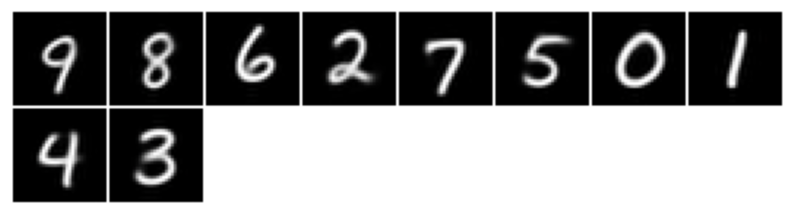

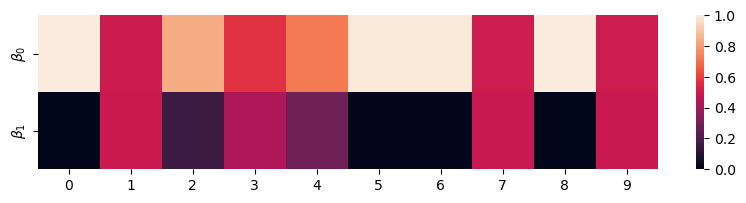

In [9]:
from clustpy.deep.semisupervised_enrc.semi_supervised_acedec import ACeDeC
from clustpy.deep.autoencoders import ConvolutionalAutoencoder
from sklearn.metrics import adjusted_rand_score as ari
device = torch.device("cuda:0")
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)
model_path = "test-convae_reproduce_model_trained_100.pth"
sd = torch.load(model_path)
ae.load_state_dict(sd.state_dict())
ae.fitted = True
ae.to(device)

aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"aug_transforms_list":[aug_transforms, None], "orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

dl = get_dataloader(data, 256, shuffle=False, additional_inputs=labels,
                   ds_kwargs={"orig_transforms_list":[orig_transforms, None]})

ae_lr = 1e-3
clustering_epochs = 5
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}

init_method = "acedec"
loss_function = "acedec"
reclustering_function = "acedec"
fit_function = _my_fitting_procedure

acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          fit_function=fit_function
          )

acedec.fit(data)

acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();

# Testing the new Approach: new torch.nn.module 

In [10]:
import torch
import numpy as np
from clustpy.deep._utils import int_to_one_hot, squared_euclidean_distance, encode_batchwise
from clustpy.deep._data_utils import get_dataloader
from clustpy.deep.semisupervised_enrc.helper_functions import _get_P, _rotate, _rotate_back, enrc_predict, \
     enrc_encode_decode_batchwise_with_loss, enrc_predict_batchwise, _are_labels_equal
from clustpy.deep.semisupervised_enrc.semi_supervised_enrc_reclustering_reinit import reinit_centers
from clustpy.deep.semisupervised_enrc.semi_supervised_enrc_init_betas import beta_weights_init


class _My_Clustering_Module(torch.nn.Module):
    """
    The ENRC torch.nn.Module.

    Parameters
    ----------
    centers : list
        list containing the cluster centers for each clustering
    P : list
        list containing projections for each clustering
    V : np.ndarray
        orthogonal rotation matrix
    beta_init_value : float
        initial values of beta weights. Is ignored if beta_weights is not None (default: 0.9)
    degree_of_space_distortion : float
        weight of the cluster loss term. The higher it is set the more the embedded space will be shaped to the assumed cluster structure (default: 1.0)
    degree_of_space_preservation : float
        weight of regularization loss term, e.g., reconstruction loss (default: 1.0)
    center_lr : float
        weight for updating the centers via mini-batch k-means. Has to be set between 0 and 1. If set to 1.0 than only the mini-batch centroid will be used,
        neglecting the past state and if set to 0 then no update is happening (default: 0.5)
    rotate_centers : bool
        if True then centers are multiplied with V before they are used, because ENRC assumes that the centers lie already in the V-rotated space (default: False)
    beta_weights : np.ndarray
        initial beta weights for the softmax (optional). If not None, then beta_init_value will be ignored (default: None)
    augmentation_invariance : bool
        If True, augmented samples provided in will be used to learn
        cluster assignments that are invariant to the augmentation transformations (default: False)

    Attributes
    ----------
    lonely_centers_count : list
        list of np.ndarrays, count indicating how often a center in a clustering has not received any updates, because no points were assigned to it.
        The lonely_centers_count of a center is reset if it has been reinitialized.
    mask_sum : list
        list of torch.tensors, contains the average number of points assigned to each cluster in each clustering over the training.
    reinit_threshold : int
        threshold that indicates when a cluster should be reinitialized. Starts with 1 and increases during training with int(np.sqrt(i+1)), where i is the number of mini-batch iterations.
    augmentation_invariance : bool (default: False)

    Raises
    ----------
    ValueError : if center_lr is not in [0,1]
    """

    def __init__(self, centers: list, P: list, V: np.ndarray, beta_init_value: float = 0.9,
                 degree_of_space_distortion: float = 1.0, degree_of_space_preservation: float = 1.0,
                 center_lr: float = 0.5, rotate_centers: bool = False, beta_weights: np.ndarray = None, augmentation_invariance: bool = False):
        super().__init__()

        self.P = P
        self.m = [len(P_i) for P_i in self.P]
        if beta_weights is None:
            beta_weights = beta_weights_init(self.P, n_dims=centers[0].shape[1], high_value=beta_init_value)
        else:
            beta_weights = torch.tensor(beta_weights).float()
        self.beta_weights = torch.nn.Parameter(beta_weights, requires_grad=True)
        self.V = torch.nn.Parameter(torch.tensor(V, dtype=torch.float), requires_grad=True)
        self.degree_of_space_distortion = degree_of_space_distortion
        self.degree_of_space_preservation = degree_of_space_preservation

        # Center specific initializations
        if rotate_centers:
            centers = [np.matmul(centers_sub, V) for centers_sub in centers]
        self.centers = [torch.tensor(centers_sub, dtype=torch.float32) for centers_sub in centers]
        if not (0 <= center_lr <= 1):
            raise ValueError(f"center_lr={center_lr}, but has to be in [0,1].")
        self.center_lr = center_lr
        self.lonely_centers_count = []
        self.mask_sum = []
        for centers_i in self.centers:
            self.lonely_centers_count.append(np.zeros((centers_i.shape[0], 1)).astype(int))
            self.mask_sum.append(torch.zeros((centers_i.shape[0], 1)))
        self.reinit_threshold = 1
        self.augmentation_invariance = augmentation_invariance

    def to_device(self, device: torch.device) -> '_ENRC_Module':
        """
        Loads all ENRC parameters to device that are needed during the training and prediction (including the learnable parameters).
        This function is preferred over the to(device) function.

        Parameters
        ----------
        device : torch.device
            device to be trained on

        Returns
        -------
        self : _ENRC_Module
            this instance of the ENRC_Module
        """
        self.to(device)
        self.centers = [c_i.to(device) for c_i in self.centers]
        self.mask_sum = [i.to(device) for i in self.mask_sum]
        return self

    def subspace_betas(self) -> torch.Tensor:
        """
        Returns a len(P) x d matrix with softmax weights, where d is the number of dimensions of the embedded space, indicating
        which dimensions belongs to which clustering.

        Returns
        -------
        self : torch.Tensor
            the dimension assignments
        """
        dimension_assignments = torch.nn.functional.softmax(self.beta_weights, dim=0)
        return dimension_assignments

    def get_P(self) -> list:
        """
        Converts the soft beta weights back to hard assignments P and returns them as a list.

        Returns
        -------
        P : list
            list containing indices for projections for each clustering
        """
        P = _get_P(betas=self.subspace_betas().detach().cpu(), centers=self.centers)
        return P

    def rotate(self, z: torch.Tensor) -> torch.Tensor:
        """
        Rotate the embedded data ponint z using the orthogonal rotation matrix V.

        Parameters
        ----------
        z : torch.Tensor
            embedded data point, can also be a mini-batch of points

        Returns
        -------
        z_rot : torch.Tensor
            the rotated embedded data point
        """
        z_rot = _rotate(z, self.V)
        return z_rot

    def rotate_back(self, z_rot: torch.Tensor) -> torch.Tensor:
        """
        Rotate a rotated embedded data point back to its original state.

        Parameters
        ----------
        z_rot : torch.Tensor
            rotated and embedded data point, can also be a mini-batch of points

        Returns
        -------
        z : torch.Tensor
            the back-rotated embedded data point
        """
        z = _rotate_back(z_rot, self.V)
        return z

    def rotation_loss(self) -> torch.Tensor:
        """
        Computes how much the rotation matrix self.V diverges from an orthogonal matrix by calculating |V^T V - I|.
        For an orthogonal matrix this difference is 0, as V^T V=I.

        Returns
        -------
        rotation_loss : torch.Tensor
            the average absolute difference between V^T times V - the identity matrix I.
        """
        ident = torch.matmul(self.V.t(), self.V).detach().cpu()
        rotation_loss = (ident - torch.eye(n=ident.shape[0])).abs().mean()
        return rotation_loss

    def update_center(self, data: torch.Tensor, one_hot_mask: torch.Tensor, subspace_id: int) -> None:
        """
        Inplace update of centers of a clusterings in subspace=subspace_id in a mini-batch fashion.

        Parameters
        ----------
        data : torch.Tensor
            data points, can also be a mini-batch of points
        one_hot_mask : torch.Tensor
            one hot encoded matrix of cluster assignments
        subspace_id : int
            integer which indicates which subspace the cluster to be updated are in

        Raises
        ----------
        ValueError: If None values are encountered.
        """
        if self.centers[subspace_id].shape[0] == 1:
            # Shared space update with only one cluster
            self.centers[subspace_id] = self.centers[subspace_id] * 0.5 + data.mean(0).unsqueeze(0) * 0.5
        else:

            batch_cluster_sums = (data.unsqueeze(1) * one_hot_mask.unsqueeze(2)).sum(0)
            mask_sum = one_hot_mask.sum(0).unsqueeze(1)
            if (mask_sum == 0).sum().int().item() != 0:
                idx = (mask_sum == 0).nonzero()[:, 0].detach().cpu()
                self.lonely_centers_count[subspace_id][idx] += 1

            # In case mask sum is zero batch cluster sum is also zero so we can add a small constant to mask sum and center_lr
            # Avoid division by a small number
            mask_sum += 1e-8
            # Use weighted average
            nonzero_mask = (mask_sum.squeeze(1) != 0)
            self.mask_sum[subspace_id][nonzero_mask] = self.center_lr * mask_sum[nonzero_mask] + (1 - self.center_lr) * \
                                                       self.mask_sum[subspace_id][nonzero_mask]

            per_center_lr = 1.0 / (1 + self.mask_sum[subspace_id][nonzero_mask])
            self.centers[subspace_id] = (1.0 - per_center_lr) * self.centers[subspace_id][
                nonzero_mask] + per_center_lr * batch_cluster_sums[nonzero_mask] / mask_sum[nonzero_mask]
            if torch.isnan(self.centers[subspace_id]).sum() > 0:
                raise ValueError(
                    f"Found nan values\n self.centers[subspace_id]: {self.centers[subspace_id]}\n per_center_lr: {per_center_lr}\n self.mask_sum[subspace_id]: {self.mask_sum[subspace_id]}\n ")

    def update_centers(self, z_rot: torch.Tensor, assignment_matrix_dict: dict) -> None:
        """
        Inplace update of all centers in all clusterings in a mini-batch fashion.

        Parameters
        ----------
        z_rot : torch.Tensor
            rotated data point, can also be a mini-batch of points
        assignment_matrix_dict : dict
            dict of torch.tensors, contains for each i^th clustering a one hot encoded matrix of cluster assignments
        """
        for subspace_i in range(len(self.centers)):
            self.update_center(z_rot.detach(),
                               assignment_matrix_dict[subspace_i],
                               subspace_id=subspace_i)

    def forward(self, z: torch.Tensor, assignment_matrix_dict: dict = None) -> (torch.Tensor, torch.Tensor, torch.Tensor, dict):
        """
        Calculates the k-means loss and cluster assignments for each clustering.

        Parameters
        ----------
        z : torch.Tensor
            embedded input data point, can also be a mini-batch of embedded points
        assignment_matrix_dict : dict
            dict of torch.tensors, contains for each i^th clustering a one hot encoded matrix of cluster assignments (default: None)

        Returns
        -------
        tuple : (torch.Tensor, torch.Tensor, torch.Tensor, dict)
            averaged sum of all k-means losses for each clustering,
            the rotated embedded point,
            the back rotated embedded point,
            dict of torch.tensors, contains for each i^th clustering a one hot encoded matrix of cluster assignments
        """
        z_rot = self.rotate(z)
        z_rot_back = self.rotate_back(z_rot)

        subspace_betas = self.subspace_betas()
        subspace_losses = 0

        if assignment_matrix_dict is None:
            assignment_matrix_dict = {}
            overwrite_assignments = True
        else:
            overwrite_assignments = False

        for i, centers_i in enumerate(self.centers):
            weighted_squared_diff = squared_euclidean_distance(z_rot, centers_i.detach(), weights=subspace_betas[i, :])
            weighted_squared_diff /= z_rot.shape[0]

            if overwrite_assignments:
                assignments = weighted_squared_diff.detach().argmin(1)
                one_hot_mask = int_to_one_hot(assignments, centers_i.shape[0])
                assignment_matrix_dict[i] = one_hot_mask
            else:
                one_hot_mask = assignment_matrix_dict[i]
            weighted_squared_diff_masked = weighted_squared_diff * one_hot_mask
            subspace_losses += weighted_squared_diff_masked.sum()

        subspace_losses = subspace_losses / subspace_betas.shape[0]
        return subspace_losses, z_rot, z_rot_back, assignment_matrix_dict

    def predict(self, z: torch.Tensor, use_P: bool = False) -> np.ndarray:
        """
        Predicts the labels for each clustering of an input z.

        Parameters
        ----------
        z : torch.Tensor
            embedded input data point, can also be a mini-batch of embedded points
        use_P: bool
            if True then P will be used to hard select the dimensions for each clustering, else the soft beta weights are used (default: False)

        Returns
        -------
        predicted_labels : np.ndarray
            n x c matrix, where n is the number of data points in z and c is the number of clusterings.
        """
        predicted_labels = enrc_predict(z=z, V=self.V, centers=self.centers, subspace_betas=self.subspace_betas(),
                                        use_P=use_P)
        return predicted_labels

    def predict_batchwise(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                          device: torch.device = torch.device("cpu"), use_P: bool = False) -> np.ndarray:
        """
        Predicts the labels for each clustering of a dataloader in a mini-batch manner.

        Parameters
        ----------
        model : torch.nn.Module
            the input model for encoding the data
        dataloader : torch.utils.data.DataLoader
            dataloader to be used for prediction
        device : torch.device
            device to be predicted on (default: torch.device('cpu'))
        use_P: bool
            if True then P will be used to hard select the dimensions for each clustering, else the soft beta weights are used (default: False)

        Returns
        -------
        predicted_labels : np.ndarray
            n x c matrix, where n is the number of data points in z and c is the number of clusterings.
        """
        predicted_labels = enrc_predict_batchwise(V=self.V, centers=self.centers, model=model, dataloader=dataloader,
                                                  subspace_betas=self.subspace_betas(), device=device, use_P=use_P)
        return predicted_labels

    def recluster(self, dataloader: torch.utils.data.DataLoader, model: torch.nn.Module, optimizer_params: dict, optimizer_class: torch.optim.Optimizer = None,
                  device: torch.device = torch.device('cpu'), rounds: int = 1, reclustering_strategy="auto", init_kwargs: dict = None) -> None:
        """
        Recluster ENRC inplace using NrKMeans or SGD (depending on the data set size, see init='auto' for details).
        Can lead to improved and more stable performance.
        Updates self.P, self.beta_weights, self.V and self.centers.

        Parameters
        ----------
        dataloader : torch.utils.data.DataLoader
            dataloader to be used for prediction
        model : torch.nn.Module
            the input model for encoding the data
        optimizer_params: dict
            parameters of the optimizer for the actual clustering procedure, includes the learning rate
        optimizer_class : torch.optim.Optimizer
            optimizer for training. If None then torch.optim.Adam will be used (default: None)
        device : torch.device
            device to be predicted on (default: torch.device('cpu'))
        rounds : int
            number of repetitions of the reclustering procedure (default: 1)
        reclustering_strategy : string
            choose which initialization strategy should be used. Has to be one of 'nrkmeans', 'random' or 'sgd' (default: 'nrkmeans')
        init_kwargs : dict
            additional parameters that are used if reclustering_strategy is a callable (optional) (default: None)
        """

        # Extract parameters
        V = self.V.detach().cpu().numpy()
        n_clusters = [c.shape[0] for c in self.centers]

        # Encode data
        embedded_data = encode_batchwise(dataloader, model, device)
        embedded_rot = np.matmul(embedded_data, V)

        # Apply reclustering in the rotated space, because V does not have to be orthogonal, so it could learn a mapping that is not recoverable by nrkmeans.
        print("reclustering values")
        print("n_clusters", n_clusters)
        print("rounds", rounds)
        print("optimizer_params", optimizer_params)
        print("optimizer_class", optimizer_class)
        print("reclustering_strategy", reclustering_strategy)
        print("init_kwargs", init_kwargs)
        print("dataloader.batch_size", dataloader.batch_size)
        print("embedded_rot shape", embedded_rot.shape)
        from clustpy.deep.semisupervised_enrc.semi_supervised_enrc_init import apply_init_function
        centers_reclustered, P, new_V, beta_weights = apply_init_function(data=embedded_rot, n_clusters=n_clusters, rounds=rounds,
                                                                max_iter=300, optimizer_params=optimizer_params, optimizer_class=optimizer_class,
                                                                init=reclustering_strategy, debug=False, init_kwargs=init_kwargs, batch_size=dataloader.batch_size,
                                                                )

        # Update V, because we applied the reclustering in the rotated space
        new_V = np.matmul(V, new_V)

        # Assign reclustered parameters
        self.P = P
        self.m = [len(P_i) for P_i in self.P]
        self.beta_weights = torch.nn.Parameter(torch.from_numpy(beta_weights).float(), requires_grad=True)
        self.V = torch.nn.Parameter(torch.tensor(new_V, dtype=torch.float), requires_grad=True)
        self.centers = [torch.tensor(centers_sub, dtype=torch.float32) for centers_sub in centers_reclustered]
        self.to_device(device)

    def fit(self, trainloader: torch.utils.data.DataLoader, evalloader: torch.utils.data.DataLoader,
            optimizer: torch.optim.Optimizer, max_epochs: int, model: torch.nn.Module,
            batch_size: int, loss_fn: torch.nn.modules.loss._Loss = torch.nn.MSELoss(),
            device: torch.device = torch.device("cpu"), print_step: int = 5, debug: bool = True,
            scheduler: torch.optim.lr_scheduler = None, fix_rec_error: bool = False,
            tolerance_threshold: float = None, data : torch.Tensor = None) -> (torch.nn.Module, '_ENRC_Module'):
        """
        Trains ENRC and the autoencoder in place.

        Parameters
        ----------
        trainloader : torch.utils.data.DataLoader
            dataloader to be used for training
        evalloader : torch.utils.data.DataLoader
            Evalloader is used for checking label change
        optimizer : torch.optim.Optimizer
            parameterized optimizer to be used
        max_epochs : int
            maximum number of epochs for training
        model : torch.nn.Module
            The underlying autoencoder
        batch_size: int
            batch size for dataloader
        loss_fn : torch.nn.modules.loss._Loss
            loss function to be used for reconstruction (default: torch.nn.MSELoss())
        device : torch.device
            device to be trained on (default: torch.device('cpu'))
        print_step : int
            specifies how often the losses are printed (default: 5)
        debug : bool
            if True than training errors will be printed (default: True)
        scheduler : torch.optim.lr_scheduler
            parameterized learning rate scheduler that should be used (default: None)
        fix_rec_error : bool
            if set to True than reconstruction loss is weighted proportionally to the cluster loss. Only used for init='sgd' (default: False)
        tolerance_threshold : float
            tolerance threshold to determine when the training should stop. If the NMI(old_labels, new_labels) >= (1-tolerance_threshold)
            for all clusterings then the training will stop before max_epochs is reached. If set high than training will stop earlier then max_epochs, and if set to 0 or None the training
            will train as long as max_epochs (default: None)
        data : torch.Tensor / np.ndarray
            dataset to be used for training (default: None)
        Returns
        -------
        tuple : (torch.nn.Module, _ENRC_Module)
            trained autoencoder,
            trained enrc module
        """
        # Deactivate Batchnorm and dropout
        model.eval()
        model.to(device)
        self.to_device(device)

        if trainloader is None and data is not None:
            trainloader = get_dataloader(data, batch_size=batch_size, shuffle=True, drop_last=True)
        elif trainloader is None and data is None:
            raise ValueError("trainloader and data cannot be both None.")
        if evalloader is None and data is not None:
            # Evalloader is used for checking label change. Only difference to the trainloader here is that shuffle=False.
            evalloader = get_dataloader(data, batch_size=batch_size, shuffle=False, drop_last=False)

        if fix_rec_error:
            if debug: print("Calculate initial reconstruction error")
            _, _, init_rec_loss = enrc_encode_decode_batchwise_with_loss(V=self.V, centers=self.centers, model=model, dataloader=evalloader, device=device, loss_fn=loss_fn)
            # For numerical stability we add a small number
            init_rec_loss += 1e-8
            if debug: print("Initial reconstruction error is ", init_rec_loss)
        i = 0
        labels_old = None
        for epoch_i in range(max_epochs):
            for batch in trainloader:
                if self.augmentation_invariance:
                    batch_data_aug = batch[1].to(device)
                    batch_data = batch[2].to(device)
                else:
                    batch_data = batch[1].to(device)

                z = model.encode(batch_data)
                subspace_loss, z_rot, z_rot_back, assignment_matrix_dict = self(z)
                reconstruction = model.decode(z_rot_back)
                rec_loss = loss_fn(reconstruction, batch_data)

                if self.augmentation_invariance:
                    z_aug = model.encode(batch_data_aug)
                    # reuse assignments
                    subspace_loss_aug, _, z_rot_back_aug, _ = self(z_aug, assignment_matrix_dict=assignment_matrix_dict)
                    reconstruction_aug = model.decode(z_rot_back_aug)
                    rec_loss_aug = loss_fn(reconstruction_aug, batch_data_aug)
                    rec_loss = (rec_loss + rec_loss_aug) / 2
                    subspace_loss = (subspace_loss + subspace_loss_aug) / 2

                if fix_rec_error:
                    rec_weight = rec_loss.item()/init_rec_loss + subspace_loss.item()/rec_loss.item()
                    if rec_weight < 1:
                        rec_weight = 1.0
                    rec_loss *= rec_weight

                summed_loss = self.degree_of_space_distortion * subspace_loss + self.degree_of_space_preservation * rec_loss
                optimizer.zero_grad()
                summed_loss.backward()
                optimizer.step()

                # Update Assignments and Centroids on GPU
                with torch.no_grad():
                    self.update_centers(z_rot, assignment_matrix_dict)
                # Check if clusters have to be reinitialized
                for subspace_i in range(len(self.centers)):
                    reinit_centers(enrc=self, subspace_id=subspace_i, dataloader=trainloader, model=model,
                                   n_samples=512, kmeans_steps=10, debug=debug)

                # Increase reinit_threshold over time
                self.reinit_threshold = int(np.sqrt(i + 1))

                i += 1
            if (epoch_i - 1) % print_step == 0 or epoch_i == (max_epochs - 1):
                with torch.no_grad():
                    # Rotation loss is calculated to check if its deviation from an orthogonal matrix
                    rotation_loss = self.rotation_loss()
                    if debug:
                        print(f"Epoch {epoch_i}/{max_epochs - 1}: summed_loss: {summed_loss.item():.4f}, subspace_losses: {subspace_loss.item():.4f}, rec_loss: {rec_loss.item():.4f}, rotation_loss: {rotation_loss.item():.4f}")

            if scheduler is not None:
                scheduler.step()

            if tolerance_threshold is not None and tolerance_threshold > 0:
                # Check if labels have changed
                labels_new = self.predict_batchwise(model=model, dataloader=evalloader, device=device, use_P=True)
                if _are_labels_equal(labels_new=labels_new, labels_old=labels_old, threshold=tolerance_threshold):
                    # training has converged
                    if debug:
                        print("Clustering has converged")
                    break
                else:
                    labels_old = labels_new.copy()

        # Extract P and m
        self.P = self.get_P()
        self.m = [len(P_i) for P_i in self.P]
        return model, self



probable MinMax normalized data detected
probable MinMax normalized data detected
probable MinMax normalized data detected
starting fitting(clustering) procedure
<function _my_fitting_procedure at 0x0000024D6BC99820>
<class '__main__._My_Clustering_Module'>
Custom dataloaders are used, X will be overwritten with testloader return values.
negative data values found
probable z-normalized data detected
Setup autoencoder
Run init:  acedec
Start encoding
Start initializing parameters
init params
acedec
None
{'lr': 0.0005}
<class 'torch.optim.adam.Adam'>
negative data values found
Normalization check was inconclusive - make sure your data is normalised
mean -0.9037005
std 6.68252
max 26.607529
min -37.436295
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger than data dimensionality
Round 0: Found solution with: 2492944.1393634826 (current best: 2492944.1393634826)
Round 1: Found solution with: 2650672.6725892043 (current best: 2492944.1393

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


enrc predict batchwise [[5 0]
 [4 0]
 [6 0]
 ...
 [6 0]
 [5 0]
 [0 0]]
enrc predict batchwise shape (70000, 2)
Betas after reclustering
[[5.6613052e-01 9.9999869e-01 5.0055993e-01 5.0118047e-01 9.9999440e-01
  5.7446474e-01 9.9999845e-01 9.1783577e-01 9.9993038e-01 9.9529982e-01]
 [4.3386954e-01 1.3014484e-06 4.9944007e-01 4.9881959e-01 5.6188155e-06
  4.2553526e-01 1.5702412e-06 8.2164161e-02 6.9669244e-05 4.7001964e-03]]
ARI: 0.8059368074032718
ARI-no-reclustering: 0.8103564005050494


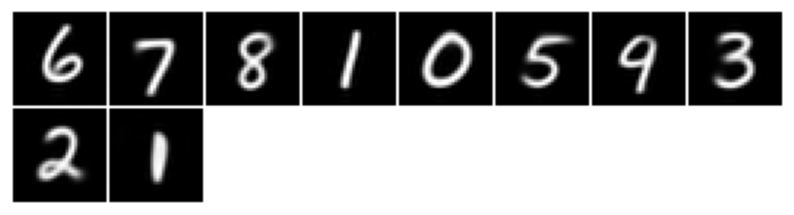

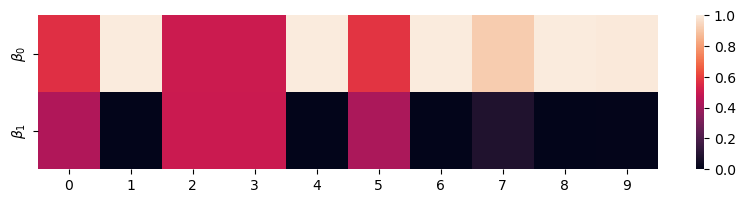

In [12]:
from clustpy.deep.semisupervised_enrc.semi_supervised_acedec import ACeDeC
from clustpy.deep.autoencoders import ConvolutionalAutoencoder
from sklearn.metrics import adjusted_rand_score as ari
device = torch.device("cuda:0")
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)
model_path = "test-convae_reproduce_model_trained_100.pth"
sd = torch.load(model_path)
ae.load_state_dict(sd.state_dict())
ae.fitted = True
ae.to(device)

aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"aug_transforms_list":[aug_transforms, None], "orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, additional_inputs=labels,
                        ds_kwargs={"orig_transforms_list":[orig_transforms, None]},
                        dl_kwargs={"num_workers":8})

dl = get_dataloader(data, 256, shuffle=False, additional_inputs=labels,
                   ds_kwargs={"orig_transforms_list":[orig_transforms, None]})

ae_lr = 1e-3
clustering_epochs = 5
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}

init_method = "acedec"
loss_function = "acedec"
reclustering_function = "acedec"
fit_function = _my_fitting_procedure
clustering_module= _My_Clustering_Module

acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          fit_function=fit_function,
          clustering_module= clustering_module
          )

acedec.fit(data)

acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();

# Apply AceDec With Augmentation With Invariance

C:\Users\Chris\anaconda3\envs\Masterarbeit\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


hier läuft
Custom dataloaders are used, X will be overwritten with testloader return values.
negative data values found
probable z-normalized data detected
Setup autoencoder
Run init:  acedec
Start encoding
Start initializing parameters
negative data values found
Normalization check was inconclusive - make sure your data is normalised
mean -1.4633311
std 6.5877705
max 29.49504
min -41.498463
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger then data dimensionality
Round 0: Found solution with: 2155636.6297160676 (current best: 2155636.6297160676)
Round 1: Found solution with: 2436218.104488579 (current best: 2155636.6297160676)
Round 2: Found solution with: 2127210.857698719 (current best: 2127210.857698719)
Round 3: Found solution with: 2437659.272601707 (current best: 2127210.857698719)
Round 4: Found solution with: 2585696.4021497634 (current best: 2127210.857698719)
Round 5: Found solution with: 2266074.940867926 (current best: 

C:\Users\Chris\anaconda3\envs\Masterarbeit\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Reinitialize cluster 4 in subspace 0
Reinitialize cluster 6 in subspace 0
Reinitialize cluster 0 in subspace 0
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 5.0000e-04.
Adjusting learning rate of group 2 to 5.0000e-03.
Epoch 1/99: summed_loss: 0.2470, subspace_losses: 0.0395, rec_loss: 0.2075, rotation_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 5.0000e-04.
Adjusting learning rate of group 2 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 5.0000e-04.
Adjusting learning rate of group 2 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 5.0000e-04.
Adjusting learning rate of group 2 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 1 to 5.0000e-04.
Adjusting learning rate of group 2 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Betas after reclustering
[[0.8911601  0.5695326  0.5464178  0.5063902  0.97725976 0.5170665
  0.98931086 0.5846649  0.6519797  0.99381375]
 [0.10883992 0.43046737 0.45358226 0.49360976 0.02274031 0.48293352
  0.01068915 0.4153351  0.3480203  0.00618626]]
ARI: 0.900935652017483
ARI-no-reclustering: 0.8883934467870829


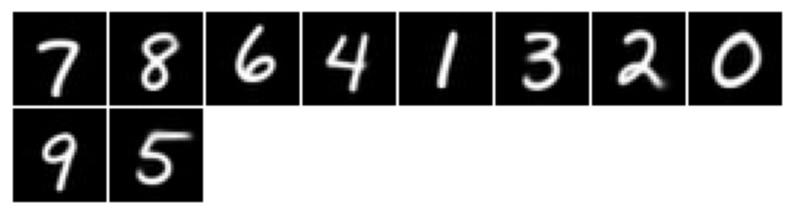

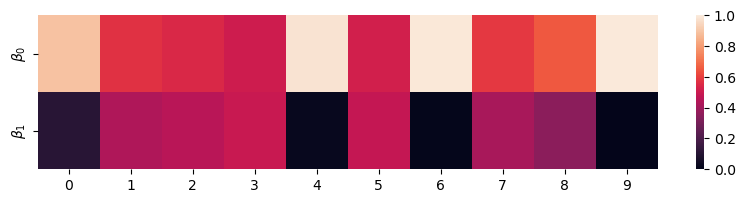

In [34]:
from clustpy.deep import ACeDeC

sd = torch.load(model_path)
ae.load_state_dict(sd.state_dict())
ae.to(device)

clustering_epochs = 100
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}


acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[aug_train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          augmentation_invariance=True,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          )
acedec.fit(data)
acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();


In [35]:
cluster_labels = acedec.predict(X=None, dataloader=dl, use_P=False)
acedec_ari2 = ari(labels, cluster_labels)
print(f"ARI: {acedec_ari2}")

ARI: 0.9084859520303774
